In [2]:
import numpy as np
import pandas as pd
from functions import *
from schemes import *
from plot import * 
from Kepler import *
from adaptive import *

%matplotlib inline

In [4]:
# gravity
G = 1

m1 = 1 
m2 = 1 
m3 = 1

R = 1

# position
r1 = np.array([-R,0.0,0.0], dtype="float64")
r2 = np.array([0,0.0,0.0], dtype="float64")
r3 = np.array([R,0.0,0.0], dtype="float64")

px = 0.347111
py = 0.532728

# velocity 
v1 = np.array([px,py,0], dtype="float64")
v2 = np.array([-2 * px,-2*py,0], dtype="float64")
v3 = np.array([px,py,0], dtype="float64")

# create initial vectors
r0s = np.array([r1,r2,r3])
v0s = np.array([v1,v2,v3])
masses = np.array([m1, m2, m3])

In [5]:
T = 1000
hlim = 0.01
Elim = 0.01
C = 0.2

def findR(v0s, E0, masses):
    ke = np.sum(KineticEnergy(v0s, masses))
    R = (2 * masses[0] + masses[0] * masses[2] + 2 * masses[2]) / (2 * (ke - E0))
    return R

In [7]:
dm1s = np.linspace(-0.0002,0.0002,20)
dm3s = np.flip(np.linspace(-0.0002, 0.0002,20))

print(dm1s, dm3s)

[-2.00000000e-04 -1.78947368e-04 -1.57894737e-04 -1.36842105e-04
 -1.15789474e-04 -9.47368421e-05 -7.36842105e-05 -5.26315789e-05
 -3.15789474e-05 -1.05263158e-05  1.05263158e-05  3.15789474e-05
  5.26315789e-05  7.36842105e-05  9.47368421e-05  1.15789474e-04
  1.36842105e-04  1.57894737e-04  1.78947368e-04  2.00000000e-04] [ 2.00000000e-04  1.78947368e-04  1.57894737e-04  1.36842105e-04
  1.15789474e-04  9.47368421e-05  7.36842105e-05  5.26315789e-05
  3.15789474e-05  1.05263158e-05 -1.05263158e-05 -3.15789474e-05
 -5.26315789e-05 -7.36842105e-05 -9.47368421e-05 -1.15789474e-04
 -1.36842105e-04 -1.57894737e-04 -1.78947368e-04 -2.00000000e-04]


In [8]:
E0 = np.sum(TotalEnergy(r0s, v0s, G, masses))

stabilities = []
ts = []
Es = []
variances = []
for dm1 in dm1s:
    for dm3 in dm3s:
        print(dm1, dm3)
        m1hat = m1 + dm1
        m3hat = m3 + dm3

        masseshat = np.array([m1hat, m2, m3hat])

        R = findR(v0s, E0, masseshat)
        
        # position
        r1hat = np.array([-R,0.0,0.0], dtype="float64")
        r2hat = np.array([0,0.0,0.0], dtype="float64")
        r3hat = np.array([R,0.0,0.0], dtype="float64")
        r0shat = np.array([r1hat,r2hat,r3hat])

        stability, variance, escapet, maxE = findStability(T, C, hlim, Elim, r0shat, v0s, G, masseshat)

        variances.append(variance)
        stabilities.append(stability)
        ts.append(escapet)
        Es.append(maxE)

stabilities = np.array(stabilities).reshape(len(dm1s), len(dm3s))
Es = np.array(stabilities).reshape(len(dm1s), len(dm3s))
ts = np.array(ts).reshape(len(dm1s), len(dm3s))
variances.append()

-0.0002 0.0002


ValueError: not enough values to unpack (expected 4, got 3)

In [ ]:
import pandas as pd 
df = pd.DataFrame(stabilities)
df.to_csv("Data/Fig8/MassStability.csv")

df = pd.DataFrame(Es)
df.to_csv("Data/Fig8/MassStability_Energy.csv")

df = pd.DataFrame(ts)
df.to_csv("Data/Fig8/MassStability_ts.csv")

NameError: name 'stabilities' is not defined

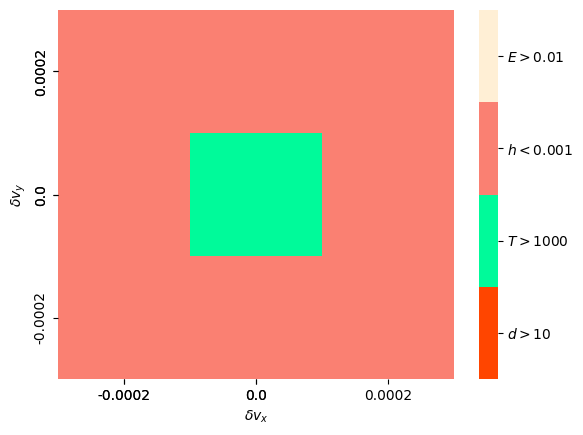

In [ ]:
import seaborn as sns
from matplotlib.colors import ListedColormap


# Create a figure and axis for the heatmap
fig, ax = plt.subplots()

cmap = ListedColormap(['orangered','mediumspringgreen','salmon','papayawhip'])
# cmap = sns.color_palette('tab10', n_colors=4)

# Create the heatmap using Seaborn
sns.heatmap(stabilities.T,cmap = cmap,  cbar=True, ax=ax, vmin=0, vmax=3)

# Determine the tick positions
num_ticks = 5
tick_positions = np.linspace(0, stabilities.shape[0] - 1, num_ticks, dtype=int) 

# Set the tick positions and labels for both x-axis and y-axis
ax.set_xticks(tick_positions + 0.5)
ax.set_yticks(tick_positions + 0.5)
ax.set_xticklabels(np.round(dm1s, 5)[tick_positions])
ax.set_yticklabels(np.round(dm3s, 5)[tick_positions])

# Set axis labels and title
ax.set_xlabel(f'$\delta v_x$')
ax.set_ylabel('$\delta v_y$')

colorbar = ax.collections[0].colorbar
colorbar.set_ticks(0.375 * np.array([1, 3, 5, 7]))
colorbar.set_ticklabels(['$d > 10$', '$T > {1000}}$', '$h < 0.001$', '$E > 0.01$'])

# Show the plot
plt.show()
